In [2]:
#!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision
! pip install GPy
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
%config InlineBackend.figure_format = 'svg'

    100% |████████████████████████████████| 880kB 20.9MB/s 
    100% |████████████████████████████████| 71kB 23.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built GPy paramz


  sum.             |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        
  white.variance   |   0.09  |      +ve      |        


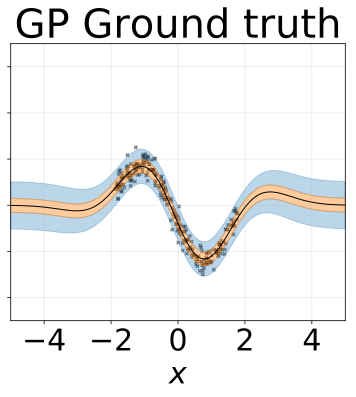

In [4]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)
#rbf = GPy.kern.MLP(input_dim=1, variance=1.0, weight_variance=1.0, bias_variance=1.0)
white = GPy.kern.White(input_dim=1, variance = 0.09)
m = GPy.models.GPRegression(x_train, y_train, rbf + white)

#m.optimize_restarts(num_restarts = 3)
print(m.parameters[0])

means, total_unc = m.predict(np.linspace(-5, 5, 200)[:, None])
means = means.reshape(-1)

aleatoric = m.parameters[0].white.parameters[0][0]**0.5
total_unc = (total_unc/2).reshape(-1)**0.5
epistemic = (total_unc**2 - aleatoric**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('GP Ground truth', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('gp_homo.pdf', bbox_inches = 'tight')

files.download("gp_homo.pdf")

plt.show()

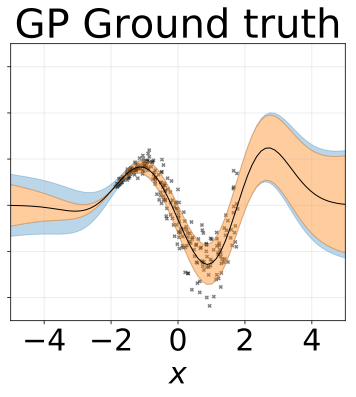

In [0]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x+2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)

mean = []
var = []
no_points = len(x_train)
all_x = np.linspace(-10, 10, 150)
for x in all_x:
    xs = np.array([[x] + list(x_train)]).T
    C = k.K(xs, xs)
    
    data_var = np.eye(no_points)*(xs[1:]-2)**2*sig_noise**2
    pred_var = np.eye(1)*(xs[:1]+2)**2*sig_noise**2
    
    mean.append(C[:1, 1:].dot(np.linalg.inv(C[1:, 1:] + data_var)).dot(y_train))
    var.append(C[:1, :1] + pred_var - C[:1, 1:].dot(np.linalg.inv(C[1:, 1:] + data_var)).dot(C[:1, 1:].T))

means = np.array(mean)[:, 0, 0]
var = np.array(var)[:, 0, 0]

aleatoric = abs(all_x+2)*sig_noise
total_unc = var**0.5
epistemic = (total_unc**2 - aleatoric**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(all_x, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(all_x, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(all_x, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(all_x, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('GP Ground truth', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('gp_hetero.pdf', bbox_inches = 'tight')

#files.download("gp_hetero.pdf")

plt.show()